In [1]:
import pickle
import time

from gep_config_parser import *

from primal_dual import PrimalDualTrainer
from gep_primal_dual_main import prep_data

CONFIG_FILE_NAME = "config.toml"



if __name__ == "__main__":
    import json

    ## Step 1: parse the input data
    print("Parsing the config file")

    data = parse_config(CONFIG_FILE_NAME)
    experiment = data["experiment"]
    outputs_config = data["outputs_config"]

    with open("config.json", "r") as file:
        args = json.load(file)
    
    print(args)

    # Train the model:
    for i, experiment_instance in enumerate(experiment["experiments"]):
        # Setup output dataframe
        df_res = pd.DataFrame(columns=["setup_time", "presolve_time", "barrier_time", "crossover_time", "restore_time", "objective_value"])

        for j in range(experiment["repeats"]):
            # Run one experiment for j repeats
            run_name = f"refactored_train:{args['train']}_rho:{args['rho']}_rhomax:{args['rho_max']}_alpha:{args['alpha']}_L:{args['alpha']}"
            save_dir = os.path.join('outputs', 'PDL',
                run_name + "-" + str(time.time()).replace('.', '-'))
            if not os.path.exists(save_dir):
                os.makedirs(save_dir)
            with open(os.path.join(save_dir, 'args.dict'), 'wb') as f:
                pickle.dump(args, f)

            target_path = f"outputs/Gurobi/Operational={args['operational']}_T={args['sample_duration']}_Scale={args['scale_problem']}_{args['G']}_{args['L']}"

            # Prep problem data:
            args["num_synthetic_samples"] = 0
            opt_data = prep_data(args=args, inputs=experiment_instance, target_path=target_path, operational=args['operational'])
            args["num_synthetic_samples"] = 8760
            synth_data = prep_data(args=args, inputs=experiment_instance, target_path=target_path, operational=args['operational'])

            # Run PDL
            # trainer = PrimalDualTrainer(data, args, save_dir)
            # primal_net, dual_net, stats = trainer.train_PDL()

            # primal_net, dual_net = load(data, save_dir)
            # data.plot_balance(primal_net, dual_net)
            # data.plot_decision_variable_diffs(primal_net, dual_net)

Running on cpu
Parsing the config file
Initializing the solver
Using Gurobi
Parsing the config file
{'N': ['BEL', 'GER'], 'G': [['BEL', 'SunPV'], ['GER', 'WindOn'], ['BEL', 'Gas'], ['GER', 'Coal']], 'L': [['BEL', 'GER']], 'operational': True, 'benders_compact': False, 'scale_problem': False, 'perturb_operating_costs': False, 'sample_duration': 1, 'outer_iterations': 2, 'inner_iterations': 1000, 'tau': 0.8, 'rho': 5.0, 'rho_max': 5000, 'alpha': 10, 'batch_size': 100, 'hidden_sizes': [500, 500], 'primal_lr': 0.0001, 'dual_lr': 0.0001, 'decay': 0.99, 'patience': 10, 'corrEps': 0.0001, 'train': 0.8, 'valid': 0.1, 'test': 0.1, 'num_synthetic_samples': 0, 'opt_targets': False}
Wrangling the input data
Creating problem instance
Populating ineq constraints
Populating eq constraints
Creating objective coefficients
Size of train set: 7007
Size of val set: 875
Size of test set: 877
Wrangling the input data
Creating problem instance
Populating ineq constraints
Populating eq constraints
Creating ob

In [3]:
opt_inv = opt_data.pUnitInvestment
synth_inv = synth_data.pUnitInvestment

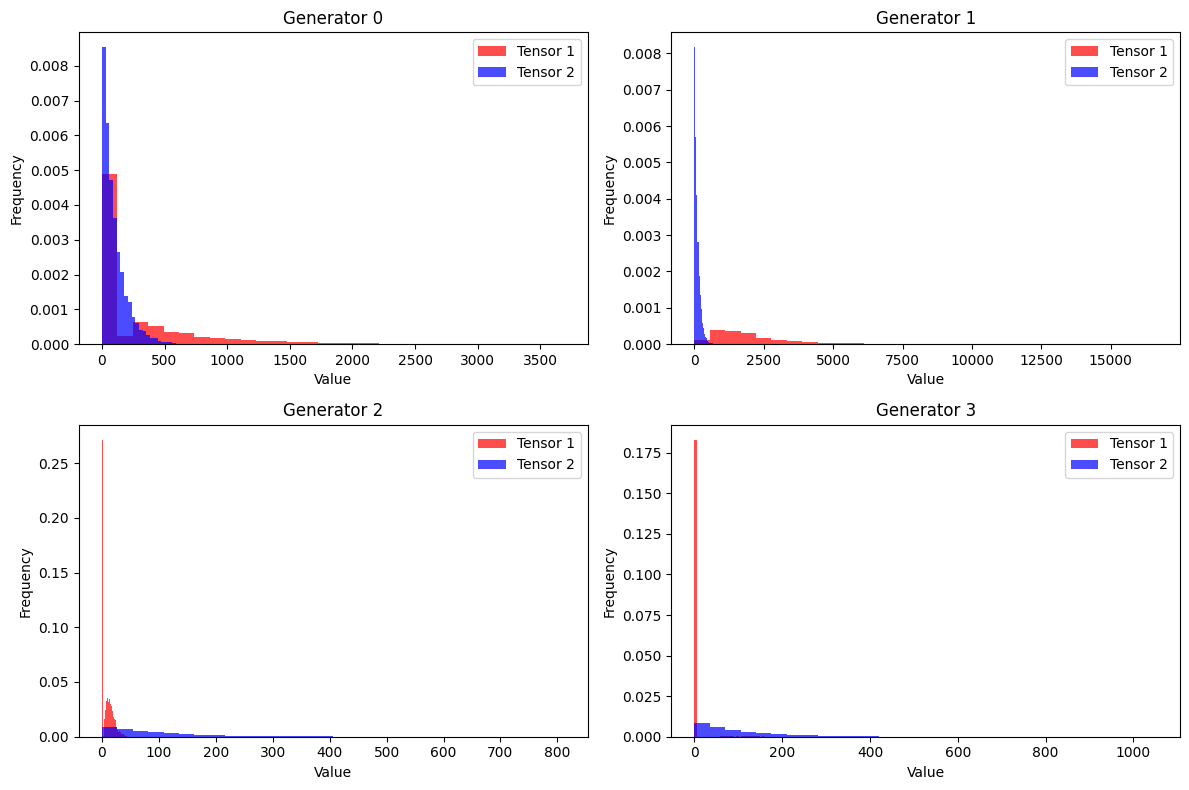

In [4]:
import matplotlib.pyplot as plt

# Create 4 subplots (2 rows x 2 columns)
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

for i in range(opt_inv.shape[1]):
    axes[i].hist(opt_inv[:, i], bins=30, density=True, alpha=0.7, color='red', label='Tensor 1')
    axes[i].hist(synth_inv[:, i], bins=30, density=True, alpha=0.7, color='blue', label='Tensor 2')
    axes[i].set_title(f"Generator {i}")
    axes[i].set_xlabel("Value")
    axes[i].set_ylabel("Frequency")
    axes[i].legend()

plt.tight_layout()
plt.show()

In [5]:
for i in range(opt_inv.shape[1]):
    print(opt_inv[:, i].mean())

tensor(297.0108)
tensor(2322.8365)
tensor(9.2854)
tensor(2.9753)


torch.Size([8759, 6])
torch.Size([8760, 6])


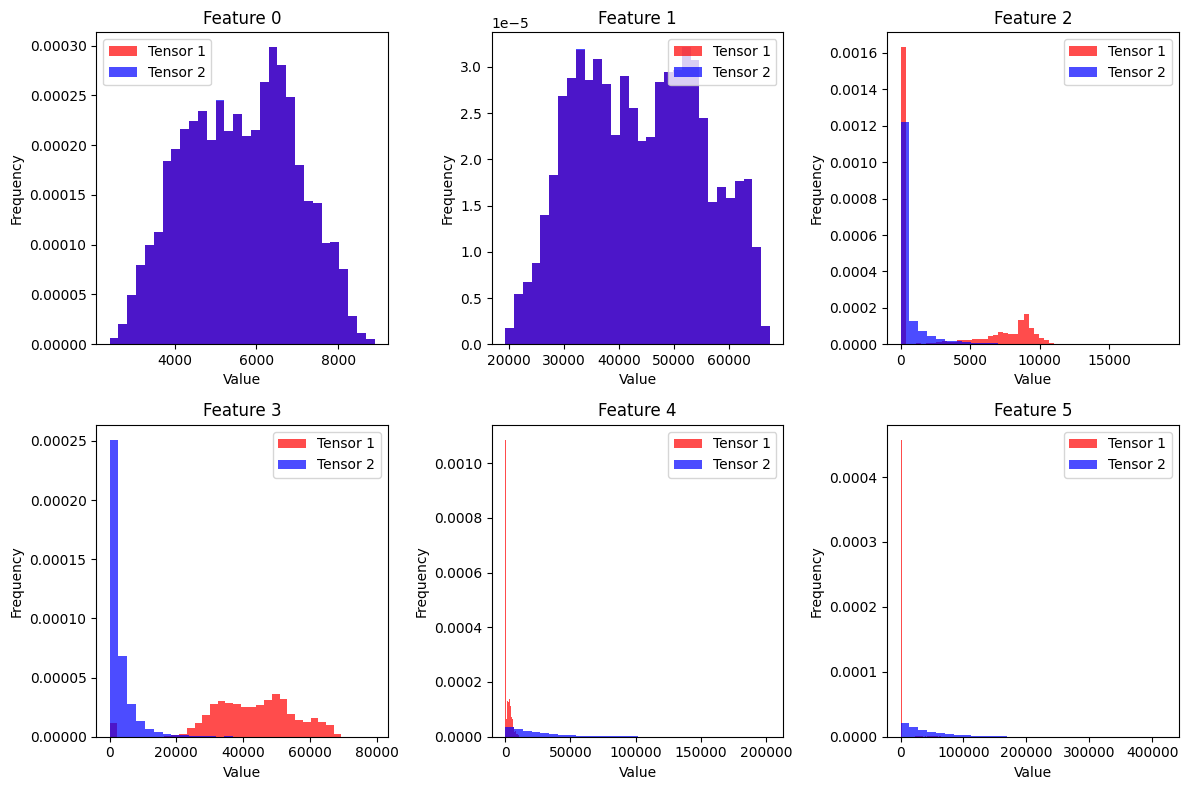

In [12]:
opt_X = opt_data.X
synth_X = synth_data.X

print(opt_X.shape)
print(synth_X.shape)

fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.flatten()

for i in range(opt_X.shape[1]):
    axes[i].hist(opt_X[:, i], bins=30, density=True, alpha=0.7, color='red', label='Tensor 1')
    axes[i].hist(synth_X[:, i], bins=30, density=True, alpha=0.7, color='blue', label='Tensor 2')
    axes[i].set_title(f"Feature {i}")
    axes[i].set_xlabel("Value")
    axes[i].set_ylabel("Frequency")
    axes[i].legend()

plt.tight_layout()
plt.show()

In [21]:
missed_demand = opt_data.opt_targets["y_gep"][:, -2:]

print(missed_demand.sum())


tensor(0.)
